## prepare environment

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
!nvidia-smi

Thu Sep 30 14:12:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install moabb
!pip install braindecode
!pip install git+https://github.com/sylvchev/beetl-competition

!pip -q install torchlibrosa
!pip -q install audiomentations
!pip install vit-pytorch
!pip install x-transformers
!pip install timm

  Cloning https://github.com/sylvchev/beetl-competition to /tmp/pip-req-build-at6o76cp
  Running command git clone -q https://github.com/sylvchev/beetl-competition /tmp/pip-req-build-at6o76cp


In [ ]:
DATA_FOLDER = "/home/data/"
OUTPUT_FOLDER = "/home/output/"
GDRIVE_DATA_FOLDER = "/gdrive/My Drive/Projects/BEETL/data/motor_imagery/"
GDRIVE_OUTPUT_FOLDER = "/gdrive/MyDrive/Projects/BEETL/output/"

In [ ]:
!mkdir {OUTPUT_FOLDER}
!mkdir {DATA_FOLDER}
!unzip -qq {GDRIVE_DATA_FOLDER}leaderboardMI.zip -d {DATA_FOLDER}
!unzip -qq {GDRIVE_DATA_FOLDER}finalMI.zip -d {DATA_FOLDER}

#!cp -R {GDRIVE_DATA_FOLDER}mne_data/ /root/

## setup

In [ ]:
import mne
from braindecode.util import set_random_seeds, np_to_var, var_to_np
from moabb.datasets import BNCI2014001, Cho2017, PhysionetMI
from moabb.paradigms import MotorImagery
from beetl.task_datasets import BeetlMILeaderboard

import pickle
import os
import time
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix

## data_utils

### preprocessing

In [ ]:
def standard_scale(data):
    mean = np.mean(data,axis=(1,2),keepdims=True)
    std = np.std(data, axis=(1,2), keepdims=True)
    data = (data - mean) / std
    return data

def robust_scale(data, q=[0.05, 0.95]):
    qs = np.quantile(data, q,axis=(1,2),keepdims=True)
    return (data - np.median(data,axis=(1,2),keepdims=True)) / (qs[1] - qs[0])


def print_stats(ds_name, data):
    print(f"{ds_name} - shape: {np.shape(data)}")
    print(f"\t- min: {np.min(data)}, max: {np.max(data)}, mean: {np.mean(data)}, std: {np.std(data)};")
    print("\t- quantiles- 5: {:.4f}, 25: {:.4f}, 50: {:.4f}, 75:{:.4f}, 95:{:.4f}\n".format(*np.quantile(data, q=[0.05, 0.25, 0.5, 0.75, 0.95])))


def relabel(l):
    if l == 'left_hand': return 0
    elif l == 'right_hand': return 1
    else: return 2

### competition data loader

In [ ]:
def load_data_MIA(folder, subject_list):
    meta_df = pd.DataFrame(columns=["type", "subject", "run"])
    # print("MIA", folder)
    X_target, y_target, X_testing = [], [], []
    for s in subject_list:
        # print("SUBJECT:", s)
        train_dir = folder + s + "/training/"
        # print(os.listdir(train_dir))
        train_files = sorted(os.listdir(train_dir), key=lambda x: int(x.split("_")[0][4:]))
        for fn in train_files:
            if fn.endswith("Data.npy"):
                # print("train", fn)
                x = np.load(train_dir + fn, allow_pickle=True)
                y = np.load(train_dir + fn.replace("Data", "Label"), allow_pickle=True)
                X_target.append(x)
                y_target.append(y)
                meta_df = meta_df.append([{"type": "train", "subject": s, "run": fn.split("_")[0]}]*len(x))
        
        test_dir = folder + s + "/testing/"
        # print(os.listdir(test_dir))
        test_files = sorted(os.listdir(test_dir), key=lambda x: int(x.split("_")[0][4:]))
        for fn in test_files:
            if fn.endswith("Data.npy"):
                # print("test", fn)
                x = np.load(test_dir + fn, allow_pickle=True)
                X_testing.append(x)
                meta_df = meta_df.append([{"type": "test", "subject": s, "run": fn.split("_")[0]}]*len(x))

    return np.concatenate(X_target), np.concatenate(y_target), np.concatenate(X_testing), meta_df

def load_data_MIB(folder, subject_list):
    meta_df = pd.DataFrame(columns=["type", "subject", "run"])
    # print("MIB", folder)
    X_target, y_target, X_testing = [], [], []
    for s in subject_list:
        # print("SUBJECT:", s)
        train_dir = folder + s + "/training/"
        # print(os.listdir(train_dir))
        train_files = sorted(os.listdir(train_dir), key=lambda x: int(x.split("_")[1][1:-5]))
        for fn in train_files:
            if fn.endswith("X.npy"):
                # print("train", fn)
                x = np.load(train_dir + fn, allow_pickle=True)
                y = np.load(train_dir + fn.replace("X", "y"), allow_pickle=True)
                X_target.append(x)
                y_target.append(y)
                meta_df = meta_df.append([{"type": "train", "subject": s, "run": fn.split("_")[1][1:-5]}]*len(x))
        
        test_dir = folder + s + "/testing/"
        # print(os.listdir(test_dir))
        test_files = sorted(os.listdir(test_dir), key=lambda x: int(x.split("_")[1][1:-5]))
        for fn in test_files:
            if fn.endswith("X.npy"):
                # print("test", fn)
                x = np.load(test_dir + fn, allow_pickle=True)
                X_testing.append(x)
                meta_df = meta_df.append([{"type": "test", "subject": s, "run": fn.split("_")[1][1:-5]}]*len(x))

    return np.concatenate(X_target), np.concatenate(y_target), np.concatenate(X_testing), meta_df

## runner_utils

In [ ]:
import os
import torch
import random
import numpy as np

def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## dataset

In [ ]:
def add_noise(data):
    if np.random.rand() > 0.5:
        data += np.random.normal(0, 0.1, (data.shape))
    return data

def handle_mixup(idx, data, label, mixup_data, supervised_mixup_data, mixup_idx, mixup_rate):
    mixup_data = mixup_data
    # use supervised mixup data if available
    if supervised_mixup_data is not None:
        mixup_data = supervised_mixup_data[label]
    # if mixup condition is set and id is not mixable
    if mixup_idx is not None and not mixup_idx[idx]:
        mixup_data = None
    # do mixup if available
    if mixup_data is not None:
        data = mixup(data, mixup_data, mixup_rate)
    
    return data

def mixup(data, mixup_data, mixup_rate):
    mixup_rate = np.random.rand() * mixup_rate
    idx = np.random.randint(0, len(mixup_data))
    return (1-mixup_rate)*data + mixup_rate*mixup_data[idx]

In [ ]:
class MIDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None, mixup_data=None, supervised_mixup_data=None, mixup_idx=None, mixup_rate=0.0):
        self.data = data.astype(np.float32)
        
        if labels is not None:
            self.labels = labels.astype(np.int64)
        else: 
            self.labels = None

        self.transform = transform
        self.mixup_data = mixup_data
        self.supervised_mixup_data = supervised_mixup_data
        self.mixup_idx = mixup_idx
        self.mixup_rate = mixup_rate

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]

        if self.labels is not None:
            label = self.labels[idx].astype(np.int64)
        else:
            label = -1
        
        ### DATA AUGMENTATION ###
        data = handle_mixup(idx, data, label, self.mixup_data, self.supervised_mixup_data, self.mixup_idx, self.mixup_rate)

        if self.transform:
            data = self.transform(data)
        ### END DATA AUGMENTATION ###

        data = data.astype(np.float32)

        return {"eeg": data, "label": label}

## runner

### Focal loss

In [ ]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    """ Focal loss with optional label smoothing.

    Calculates mean focal loss over given data with optional label smoothing.

    Attributes
    ----------
        alpha: int = 1
        gamma: int = 2
        logits: bool = True
        reduce: bool = True
        ls: float = None
            label smoothing ratio, if None label smoothing will not be applied
        classes: int = None
            number of classes required for label smoothing
    """

    def __init__(
        self,
        alpha: int = 1,
        gamma: int = 2,
        logits: bool = True,
        reduce: bool = True,
        ls: float = 0.05,
        classes: int = 3,
    ):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        self.ls = ls
        self.classes = classes

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=self.classes)

        if self.ls is not None:
            targets = (1 - self.ls) * targets + self.ls / self.classes

        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### VAT

In [ ]:
# implementation from: https://github.com/lyakaap/VAT-pytorch

import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F


@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d


class VATLoss(nn.Module):

    def __init__(self, xi=10.0, eps=1.0, ip=1):
        """VAT loss
        :param xi: hyperparameter of VAT (default: 10.0)
        :param eps: hyperparameter of VAT (default: 1.0)
        :param ip: iteration times of computing adv noise (default: 1)
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip

    def forward(self, model, x):
        with torch.no_grad():
            pred = F.softmax(model(x), dim=1)

        # prepare random unit tensor
        d = torch.rand(x.shape).sub(0.5).to(x.device)
        d = _l2_normalize(d)

        with _disable_tracking_bn_stats(model):
            # calc adversarial direction
            for _ in range(self.ip):
                d.requires_grad_()
                pred_hat = model(x + self.xi * d)
                logp_hat = F.log_softmax(pred_hat, dim=1)
                adv_distance = F.kl_div(logp_hat, pred, reduction='batchmean')
                adv_distance.backward()
                d = _l2_normalize(d.grad)
                model.zero_grad()
    
            # calc LDS
            r_adv = d * self.eps
            pred_hat = model(x + r_adv)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            lds = F.kl_div(logp_hat, pred, reduction='batchmean')

        return lds

### train, validate, predict

In [ ]:
import torch
import numpy as np

def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = []
    targets_all = []
    outputs_all = []

    vat_loss = VATLoss(xi=10.0, eps=1.0, ip=1)

    model.train()
    t = tqdm(loader)

    for i, sample in enumerate(t):
        optimizer.zero_grad()

        eeg = sample["eeg"].to(args.device)
        target = sample["label"].to(args.device)

        lds = vat_loss(model, eeg)
        output = model(eeg)
        loss = criterion(output, target) + args.alpha * lds
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        losses.append(loss.item())
        
        target = target.cpu().numpy()
        output = output.detach().cpu().numpy()

        targets_all.extend(target)
        outputs_all.extend(output)

        output_loss = np.mean(losses)
        output_score = np.mean(targets_all == np.argmax(outputs_all, axis=1))

        t.set_description(
            f"Epoch {epoch}/{args.epochs} - Train loss: {output_loss:0.4f}, score: {output_score:0.4f}"
        )

    return targets_all, outputs_all, output_score, output_loss


def validate(args, model, loader, criterion, desc="Valid"):
    losses = []
    targets_all = []
    outputs_all = []

    t = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(t):
            eeg = sample["eeg"].to(args.device)
            target = sample["label"].to(args.device)

            output = model(eeg)
            loss = criterion(output, target)

            losses.append(loss.item())
            targets_all.extend(target.cpu().numpy())
            outputs_all.extend(output.detach().cpu().numpy())

            output_loss = np.mean(losses)
            output_score = np.mean(targets_all == np.argmax(outputs_all, axis=1))

            t.set_description(
                f"\t  - {desc} loss: {output_loss:0.4f}, score: {output_score:0.4f}"
            )

    return targets_all, outputs_all, output_score, output_loss


def predict(args, model, loader):
    outputs_all = []

    t = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(t):
            eeg = sample["eeg"].to(args.device)

            output = model(eeg)
            outputs_all.extend(output.detach().cpu().numpy())
    return outputs_all

### experiment helper functions

In [ ]:
def train_model(args, model, 
          train_data, train_labels, 
          valid_data, valid_labels, 
          train_weights=None, sample_rate=None, 
          use_scheduler=True,
          history = {"Train": {"Score": [], "Loss": []}, 
                     "Valid": {"Score": [], "Loss": []}},
          mixup_data=None, supervised_mixup_data=None, mixup_idx=None, mixup_rate=0.0,
          validate_test=None):
    
    train_dataset = MIDataset(train_data, train_labels, transform=add_noise, 
                              mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data, mixup_idx=mixup_idx, mixup_rate=mixup_rate)
    
    if train_weights is not None:
        train_sampler = WeightedRandomSampler(weights = train_weights, num_samples=int(len(train_labels)*sample_rate))
        train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, sampler=train_sampler, drop_last=True)
    else:
        train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True, drop_last=True)

    model = model.to(args.device)
    criterion = FocalLoss(classes=args.n_classes)
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=5e-4)

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
                        optimizer,
                        max_lr=args.lr,
                        epochs=args.epochs,
                        steps_per_epoch=len(train_loader),
                        div_factor=10, 
                        final_div_factor=10,
                        pct_start=0.1,
                        anneal_strategy="cos",
                    )
    else:
        scheduler = None
    
    for epoch in range(1, args.epochs+1):
        _, _, train_score, train_loss = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        _, _, valid_score, valid_loss = validate_model(args, model, valid_data, valid_labels, show_plot=False)
        if validate_test is not None:
            _, _, _, _ = validate_model(args, model, validate_test[0], validate_test[1], desc="Test", show_plot=False)


        history["Train"]["Loss"].append(train_loss)
        history["Train"]["Score"].append(train_score)
        history["Valid"]["Loss"].append(valid_loss)
        history["Valid"]["Score"].append(valid_score)

    torch.save(model.state_dict(), f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt")


def validate_model(args, model, valid_data, valid_labels, desc="Target", show_plot=True):
    criterion = FocalLoss(classes=args.n_classes)

    valid_dataset = MIDataset(valid_data, valid_labels)
    valid_loader = DataLoader(valid_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
    targets_all, outputs_all, output_score, output_loss = validate(args, model, valid_loader, criterion, desc)
    
    if show_plot:
        plot_conf_matrix(targets_all, outputs_all)

    return targets_all, outputs_all, output_score, output_loss

def plot_conf_matrix(targets_all, outputs_all):
    cf_mat = confusion_matrix(targets_all, np.argmax(outputs_all, axis=1), normalize="true")
    plt.figure()
    sns.heatmap(cf_mat, annot=True)
    plt.show()


def get_prediction(args, model, data):
    model.to(args.device)
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    
    dataset = MIDataset(data, None)
    loader = DataLoader(dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)

    output = predict(args, model, loader)
    return output


def ensemble(args_array, dataset_name="test", phase=None):
    ensemble_output = None

    for args in args_array:
        if phase is None:
            fn = f"{OUTPUT_FOLDER}{args.get_model_name()}-{dataset_name}_output.npy"
        else:
            fn = f"{OUTPUT_FOLDER}{args.model_name}_{phase}-{dataset_name}_output.npy"
            
        output = np.load(fn)
        if ensemble_output is None:
            ensemble_output = output
        else:
            ensemble_output += output
    
    return ensemble_output
    

def predict_and_save(args, model, target_data, test_data):
    target_output = get_prediction(args, model, target_data)
    np.save(f"{OUTPUT_FOLDER}{args.get_model_name()}-target_output.npy", target_output)
    
    test_output = get_prediction(args, model, test_data)
    np.save(f"{OUTPUT_FOLDER}{args.get_model_name()}-test_output.npy", test_output)


def plot_history(history):
    fig, axes = plt.subplots(2,1, figsize=(22,6))
    axes[0].plot(history["Train"]["Score"], label="Train score")
    axes[0].plot(history["Valid"]["Score"], label="Valid score")
    axes[0].legend()
    axes[1].plot(history["Train"]["Loss"], label="Train loss")
    axes[1].plot(history["Valid"]["Loss"], label="Valid loss")
    axes[1].legend()
    fig.show()

## model

### base model

In [ ]:
# implementation from: https://github.com/Shenyonglong/Spatial-Temporal-attention-/tree/master/models

import numpy as np
import torch
from torch.nn import Module,  Conv2d, ReLU, Parameter, Softmax, Dropout


class Time_Module(Module):
    """ time attention module"""
    def __init__(self, in_dim, channel_num):
        super(Time_Module, self).__init__()
        self.channel_in = in_dim

        self.conv1 = Conv2d(in_channels=in_dim, out_channels=in_dim * 8, kernel_size=(1, 1))

        self.conv2 = Conv2d(in_channels=in_dim, out_channels=in_dim * 8, kernel_size=(1, 1))

        self.gamma = Parameter(torch.zeros(1))


        self.softmax = Softmax(dim=2)

    def forward(self, x):
        """
        :param x: input feature maps( B X C X H X W)
        :return: out : attention value + input feature
        """
        mini_batchsize, C, Height, Width = x.size()
        proj_query = self.conv1(x).permute(0,2,1,3).reshape(mini_batchsize, Height, 8 * Width)
        proj_key = self.conv2(x).permute(0,1,3,2).reshape(mini_batchsize, 8 * Width, Height)
        energy = torch.matmul(proj_query, proj_key)

        max_H, _ = energy.max(dim=2, keepdim=True)
        min_H, _ = energy.min(dim=2, keepdim=True)
        temp_b = (energy - min_H)
        temp_c = (max_H - min_H)+0.00000001
        energy = temp_b / temp_c
        attention = self.softmax(energy)

        attention = attention.reshape(mini_batchsize, 1, Height, Height)

        out = torch.matmul(attention, x)

        out = self.gamma*out + x
        return out

class Channel_Module(Module):
    """ Channel attention module"""
    def __init__(self, in_dim):
        super(Channel_Module, self).__init__()
        self.chanel_in = in_dim

        self.conv1 = Conv2d(in_channels=in_dim, out_channels=in_dim * 8, kernel_size=(1, 1))

        self.conv2 = Conv2d(in_channels=in_dim, out_channels=in_dim * 8, kernel_size=(1, 1))

        self.gamma = Parameter(torch.zeros(1))
        self.softmax = Softmax(dim=2)


    def forward(self, x):
        """
        :param x: input feature maps( B X C X H X W)
        :return: out : attention value + input feature
        """
        mini_batchsize, C, Height, Width = x.size()
        queryv = self.conv1(x).permute(0,3,1,2).reshape(mini_batchsize, Width, 8 * Height)
        key = self.conv2(x).reshape(mini_batchsize, 8 * Height, Width)
        energy = torch.matmul(queryv, key)

        max_H, _ = energy.max(dim=2, keepdim=True)
        min_H, _ = energy.min(dim=2, keepdim=True)
        temp_b = (energy - min_H)
        temp_c = (max_H - min_H)+0.00000001
        energy = temp_b / temp_c
        attention = self.softmax(energy)

        attention = attention.reshape(mini_batchsize, 1, Width, Width)
        out = torch.matmul(x, attention.permute(0,1,3,2))

        out = self.gamma * out + x

        return out

class Attention(Module):
    def __init__(self, in_dim, channel_num):
        super(Attention, self).__init__()
        self.ca = Channel_Module(in_dim)
        self.ta = Time_Module(in_dim, channel_num)

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 1, stride=1),
            torch.nn.BatchNorm2d(16, momentum=0.1, affine=True),
        )

    def forward(self, x):
        out1 = self.ca(x)
        out2 = self.ta(x)
        out = torch.cat((x, out1, out2), dim=1)

        return out

In [ ]:
import torch.nn as nn
import numpy as np
from braindecode.models.modules import Expression
from braindecode.util import np_to_var
from torch.nn import init
from braindecode.models.functions import safe_log, square
from torch.nn.functional import elu
import torch


def base_model(in_chans):
    fixmodel = CreateBase(in_chans)
    return fixmodel


def _transpose_time_to_spat(x):
    return x.permute(0, 3, 2, 1)


def _transpose_spat_to_time(x):
    x = x.permute(0, 3, 2, 1)
    return x.contiguous()


def _squeeze_final_output(x):
    assert x.size()[3] == 1
    x = x[:, :, :, 0]
    if x.size()[2] == 1:
        x = x[:, :, 0]
    return x


class CreateBase(nn.Module):
    def __init__(self, in_chans,
                 n_filters_time=64,
                 n_filters_spat=64,
                 filter_time_length=25,
                 pool_time_length=75,
                 pool_time_stride=15,
                 conv_nonlin=square,
                 pool_nonlin=safe_log,
                 drop_prob=0.3,
                 batch_norm=True,
                 batch_norm_alpha=0.1):
        super(CreateBase, self).__init__()

        #       block1

        self.attn = Attention(in_dim=1, channel_num=1)
        self.conv_time = nn.Conv2d(3, n_filters_time,
                                   (filter_time_length, 1),
                                   stride=1, )
        init.xavier_uniform_(self.conv_time.weight, gain=1)
        init.constant_(self.conv_time.bias, 0)
        self.conv_spat = nn.Conv2d(n_filters_time, n_filters_spat,
                                   (1, in_chans),
                                   stride=(1, 1),
                                   bias=not batch_norm)
        init.xavier_uniform_(self.conv_spat.weight, gain=1)



        self.bnorm_attn = nn.BatchNorm2d(3,
                                    momentum=batch_norm_alpha,
                                    affine=True)
        init.constant_(self.bnorm_attn.weight, 1)
        init.constant_(self.bnorm_attn.bias, 0)

        self.bnorm_time = nn.BatchNorm2d(n_filters_time,
                                    momentum=batch_norm_alpha,
                                    affine=True)
        init.constant_(self.bnorm_time.weight, 1)
        init.constant_(self.bnorm_time.bias, 0)

        self.bnorm = nn.BatchNorm2d(n_filters_spat,
                                    momentum=batch_norm_alpha,
                                    affine=True)
        init.constant_(self.bnorm.weight, 1)
        init.constant_(self.bnorm.bias, 0)



        self.conv_nonlin = Expression(conv_nonlin)
        self.pool = nn.AvgPool2d(
            kernel_size=(pool_time_length, 1),
            stride=(pool_time_stride, 1))
        self.pool_nonlin = Expression(pool_nonlin)
        self.drop = nn.Dropout(p=drop_prob)

    def forward(self, data):
        data = _transpose_time_to_spat(data)
        data = self.bnorm_attn(self.attn(data))
        data = self.bnorm_time(self.conv_time(data))
        data = self.bnorm(self.conv_spat(data))
        data = self.pool(self.conv_nonlin(data))
        data = self.drop(self.pool_nonlin(data))
        return data


class EEGClassifier(nn.Module):

    def __init__(self, n_out_time, filtersize=50, n_classes=4):
        super(EEGClassifier, self).__init__()

        self.conv_class_s = nn.Conv2d(filtersize, n_classes,
                                      (n_out_time, 1), bias=True)
        init.xavier_uniform_(self.conv_class_s.weight, gain=1)
        init.constant_(self.conv_class_s.bias, 0)
        self.softmax_s = nn.LogSoftmax(dim=1)
        self.squeeze_s = Expression(_squeeze_final_output)

    def forward(self, data):
        return self.squeeze_s(self.softmax_s(self.conv_class_s(data)))


class EEGShallowClassifier(nn.Module):
    def __init__(self, in_chans, n_classes, input_time_length, return_feature=False,reductionsize=50,cat_features=0,if_reduction=True,if_deep=False):
        super(EEGShallowClassifier, self).__init__()
        self.basenet = base_model(in_chans)
        x0 = np_to_var(np.ones(
            (1, in_chans, input_time_length, 1),
            dtype=np.float32))

        x0 = self.basenet(x0)
        n_out = x0.cpu().data.numpy().shape
        filtersize=n_out[1]
        n_out_time = n_out[2]
        print('feature shape is: ', n_out)
        
        if if_reduction:
            self.feature_reduction = nn.Conv2d(filtersize, reductionsize, (n_out_time, 1), bias=True)
            init.xavier_uniform_(self.feature_reduction.weight, gain=1)
            init.constant_(self.feature_reduction.bias, 0)
            if if_deep:
                self.deep1 = nn.Conv2d(reductionsize, reductionsize,
                                      (1, 1), bias=True)
                init.xavier_uniform_(self.deep1.weight, gain=1)
                init.constant_(self.deep1.bias, 0)
                
                self.deep2 = nn.Conv2d(reductionsize, reductionsize,
                                      (1, 1), bias=True)
                init.xavier_uniform_(self.deep2.weight, gain=1)
                init.constant_(self.deep2.bias, 0)
                
                self.deep3 = nn.Conv2d(reductionsize, reductionsize,
                                      (1, 1), bias=True)
                init.xavier_uniform_(self.deep3.weight, gain=1)
                init.constant_(self.deep3.bias, 0)
                x0=self.deep3(self.deep2(self.deep1(self.feature_reduction(x0))))
            else:
                x0=self.feature_reduction(x0)

            n_out = x0.cpu().data.numpy().shape
            print('feature reduction shape is: ', n_out)
            # self.classifier = EEGClassifier(n_out_time=1, n_classes=n_classes,filtersize=reductionsize+cat_features)
            self.classifier = nn.Sequential(nn.Flatten(), nn.utils.weight_norm(nn.Linear(reductionsize+cat_features, n_classes)))
        else:
            # self.classifier = EEGClassifier(n_out_time=n_out_time, n_classes=n_classes,filtersize=filtersize+cat_features)
            self.classifier = nn.Sequential(nn.Flatten(), nn.utils.weight_norm(nn.Linear(filtersize+cat_features, n_classes)))
        
        self.return_feature = return_feature
        self.if_reduction = if_reduction
        self.if_deep = if_deep
    def forward(self, data, cat_feature=None):
        data = data.unsqueeze(-1)
        feature = self.basenet(data)
        
        if self.return_feature:
            return feature
        if self.if_reduction:
            if self.if_deep:
                feature = self.deep3(self.deep2(self.deep1(self.feature_reduction(feature))))
            else:
                feature = self.feature_reduction(feature)
            if cat_feature is not None:
                    feature = torch.cat((feature,cat_feature),1)
            y = self.classifier(feature)
            return y
        else:
            if cat_feature is not None:
                feature = torch.cat((feature,cat_feature),1)
            y = self.classifier(feature)
            return y

### ViT model

In [ ]:
# import torch
# import torch.nn as nn

# from vit_pytorch import ViT
# from torchlibrosa.stft import Spectrogram, LogmelFilterBank

# class EEGViTModule(nn.Module):
#     def __init__(self):
#         super(EEGViTModule, self).__init__()

#         window = 'hann'
#         center = True
#         pad_mode = 'reflect'
        
#         self.spectrogram_extractor = Spectrogram(n_fft=128, hop_length=32, 
#             win_length=64, window=window, center=center, pad_mode=pad_mode, 
#             freeze_parameters=True)
        

#         self.encoder = ViT(
#             image_size = (247,65),
#             patch_size = (19,13),
#             num_classes = 3,
#             dim = 256,
#             depth = 2,
#             heads = 4,
#             mlp_dim = 128,
#             dropout = 0.2,
#             emb_dropout = 0.2
#         )

#     def forward(self, x):
#         x_spec = [self.spectrogram_extractor(x[:, i, :]) for i in range(13)]
#         x = torch.cat(x_spec, axis=2)
#         x = torch.cat([x,x,x], axis=1)
#         x = self.encoder(x)
#         return x

### CNN model

In [ ]:
# import timm

# def get_linear(in_features, out_features):
#     return nn.utils.weight_norm(nn.Linear(in_features, out_features))

# class EEGCnnModule(nn.Module):
#     def __init__(self):
#         super(EEGCnnModule, self).__init__()

#         window = 'hann'
#         center = True
#         pad_mode = 'reflect'
        
#         self.spectrogram_extractor = Spectrogram(n_fft=128, hop_length=32, 
#             win_length=64, window=window, center=center, pad_mode=pad_mode, 
#             freeze_parameters=True)
        
#         self.encoder = timm.create_model("resnet18", pretrained=False)
#         self.features = self.encoder.get_classifier().in_features
#         self.encoder.fc = get_linear(self.features, 4)

#     def forward(self, x):
#         x_spec = [self.spectrogram_extractor(x[:, i, :]) for i in range(13)]
#         x = torch.cat(x_spec, axis=2)
#         x = torch.cat([x,x,x], axis=1)
#         x = self.encoder(x)
#         return x

## prepare data

### load data

In [ ]:
ds_MIA_ch_names = ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']
ds_MIB_ch_names = ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC1', 'FC2','FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8']
FS_MIA = 500
FS_MIB = 200

In [ ]:
X_MIA_LB_target, y_MIA_LB_target, X_MIA_LB_test, X_MIA_LB_meta_df = load_data_MIA(DATA_FOLDER + "leaderboardMI/", ["S1", "S2"])
X_MIB_LB_target, y_MIB_LB_target, X_MIB_LB_test, X_MIB_LB_meta_df = load_data_MIB(DATA_FOLDER + "leaderboardMI/", ["S3", "S4", "S5"])

X_MIA_FN_target, y_MIA_FN_target, X_MIA_FN_test, X_MIA_FN_meta_df = load_data_MIA(DATA_FOLDER + "finalMI/", ["S1", "S2", "S3"])
X_MIB_FN_target, y_MIB_FN_target, X_MIB_FN_test, X_MIB_FN_meta_df = load_data_MIB(DATA_FOLDER + "finalMI/", ["S4", "S5"])

In [ ]:
ds_src1 = Cho2017()
ds_src2 = PhysionetMI()
ds_src3 = BNCI2014001()

In [ ]:
ds_src1_ch_names = ds_src1.get_data(subjects=[1])[1]['session_0']['run_0'].pick_types(eeg=True).ch_names
ds_src2_ch_names = ds_src2.get_data(subjects=[1])[1]['session_0']['run_10'].pick_types(eeg=True).ch_names
ds_src3_ch_names = ds_src3.get_data(subjects=[1])[1]['session_T']['run_1'].pick_types(eeg=True).ch_names

Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


In [ ]:
sfreq = 100.
fmin, fmax = 4, 30

tgt_ch_names = list(set(ds_src1_ch_names) & \
                    set(ds_src2_ch_names) & \
                    set(ds_src3_ch_names) & \
                    set(ds_MIA_ch_names) & \
                    set(ds_MIB_ch_names))

print("Common channels: ", tgt_ch_names)

Common channels:  ['P1', 'CPz', 'CP4', 'CP3', 'FC2', 'C4', 'C1', 'P2', 'CP2', 'C5', 'C2', 'CP1', 'FC1', 'Fz', 'Pz', 'C6', 'C3']


In [ ]:
def preprocess_MI_ds(X_target, X_test, FS, ds_ch_names, tgt_ch_names=tgt_ch_names, fmin=fmin, fmax=fmax, sfreq=sfreq):
    X_target = np.array(X_target, dtype=np.float64)
    valid_ds_ch_names = [ch_name in tgt_ch_names for ch_name in ds_ch_names]

    X_target = X_target[:, valid_ds_ch_names, :]
    X_target = mne.filter.filter_data(np.array(X_target, dtype=np.float64), FS, fmin, fmax, method="iir", verbose=False)
    X_target = mne.filter.resample(X_target, down=FS/sfreq)

    X_test = np.array(X_test, dtype=np.float64)
    X_test = X_test[:, valid_ds_ch_names, :]
    X_test = mne.filter.filter_data(np.array(X_test, dtype=np.float64), FS, fmin, fmax, method="iir", verbose=False)
    X_test = mne.filter.resample(X_test, down=FS/sfreq)

    return X_target, X_test

In [ ]:
### PREPARE BEETL MI DATASET ###
X_MIA_LB_target, X_MIA_LB_test = preprocess_MI_ds(X_MIA_LB_target, X_MIA_LB_test, FS_MIA, ds_MIA_ch_names)
X_MIA_FN_target, X_MIA_FN_test = preprocess_MI_ds(X_MIA_FN_target, X_MIA_FN_test, FS_MIA, ds_MIA_ch_names)

X_MIB_LB_target, X_MIB_LB_test = preprocess_MI_ds(X_MIB_LB_target, X_MIB_LB_test, FS_MIB, ds_MIB_ch_names)
X_MIB_FN_target, X_MIB_FN_test = preprocess_MI_ds(X_MIB_FN_target, X_MIB_FN_test, FS_MIB, ds_MIB_ch_names)

In [ ]:
### LOAD SOURCE DATA ###
prgm_2classes = MotorImagery(n_classes=2, channels=tgt_ch_names, resample=sfreq, fmin=fmin, fmax=fmax)
prgm_4classes = MotorImagery(n_classes=4, channels=tgt_ch_names, resample=sfreq, fmin=fmin, fmax=fmax)

X_src1, label_src1, m_src1 = prgm_2classes.get_data(dataset=ds_src1, subjects=[1, 2, 3, 4, 5, 6, 7, 8])
X_src2, label_src2, m_src2 = prgm_4classes.get_data(dataset=ds_src2, subjects=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
X_src3, label_src3, m_src3 = prgm_4classes.get_data(dataset=ds_src3, subjects=[1, 2, 3, 4, 5, 6, 7, 8])

Choosing from all possible events
Choosing from all possible events
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


In [ ]:
# !cp -R /root/mne_data/ {GDRIVE_DATA_FOLDER}

In [ ]:
print("First source dataset has {} trials with {} electrodes and {} time samples".format(*X_src1.shape))
print("Second source dataset has {} trials with {} electrodes and {} time samples".format(*X_src2.shape))
print("Third dataset has {} trials with {} electrodes and {} time samples".format(*X_src3.shape))

print("MI leaderboard A Target: There are {} trials with {} electrodes and {} time samples".format(*X_MIA_LB_target.shape))
print("MI leaderboard A Test: There are {} trials with {} electrodes and {} time samples".format(*X_MIA_LB_test.shape))
print("MI leaderboard B Target: There are {} trials with {} electrodes and {} time samples".format(*X_MIB_LB_target.shape))
print("MI leaderboard B Test: There are {} trials with {} electrodes and {} time samples".format(*X_MIB_LB_test.shape))

print("MI final A Target: There are {} trials with {} electrodes and {} time samples".format(*X_MIA_FN_target.shape))
print("MI final A Test: There are {} trials with {} electrodes and {} time samples".format(*X_MIA_FN_test.shape))
print("MI final B Target: There are {} trials with {} electrodes and {} time samples".format(*X_MIB_FN_target.shape))
print("MI final B Test: There are {} trials with {} electrodes and {} time samples".format(*X_MIB_FN_test.shape))

print("\nSource dataset 1 include labels: {}".format(np.unique(label_src1)))
print("Source dataset 2 include labels: {}".format(np.unique(label_src2)))
print("Source dataset 3 include labels: {}".format(np.unique(label_src3)))
print("MIA leaderboard target dataset include labels: {}".format(np.unique(y_MIA_LB_target)))
print("MIB leaderboard target dataset include labels: {}".format(np.unique(y_MIB_LB_target)))
print("MIA final target dataset include labels: {}".format(np.unique(y_MIA_FN_target)))
print("MIB final target dataset include labels: {}".format(np.unique(y_MIB_FN_target)))

First source dataset has 1640 trials with 17 electrodes and 300 time samples
Second source dataset has 1260 trials with 17 electrodes and 301 time samples
Third dataset has 4608 trials with 17 electrodes and 400 time samples
MI leaderboard A Target: There are 200 trials with 17 electrodes and 400 time samples
MI leaderboard A Test: There are 400 trials with 17 electrodes and 400 time samples
MI leaderboard B Target: There are 360 trials with 17 electrodes and 400 time samples
MI leaderboard B Test: There are 600 trials with 17 electrodes and 400 time samples
MI final A Target: There are 300 trials with 17 electrodes and 400 time samples
MI final A Test: There are 600 trials with 17 electrodes and 400 time samples
MI final B Target: There are 240 trials with 17 electrodes and 400 time samples
MI final B Test: There are 400 trials with 17 electrodes and 400 time samples

Source dataset 1 include labels: ['left_hand' 'right_hand']
Source dataset 2 include labels: ['feet' 'hands' 'left_han

### normalize data

In [ ]:
norm_fn = standard_scale

print_stats("Cho2017", X_src1)
print_stats("PhysionetMI", X_src2)
print_stats("BNCI2014001", X_src3)
print_stats("MIA_LB_target", X_MIA_LB_target)
print_stats("MIB_LB_target", X_MIB_LB_target)
print_stats("MIA_LB_test", X_MIA_LB_test)
print_stats("MIB_LB_test", X_MIB_LB_test)
print_stats("MIA_FN_target", X_MIA_FN_target)
print_stats("MIB_FN_target", X_MIB_FN_target)
print_stats("MIA_FN_test", X_MIA_FN_test)
print_stats("MIB_FN_test", X_MIB_FN_test)

print("\nRESCALED DATA\n")
X_src1 = norm_fn(X_src1)
X_src2 = norm_fn(X_src2)
X_src3 = norm_fn(X_src3)

X_MIA_LB = np.concatenate((X_MIA_LB_target, X_MIA_LB_test))
X_MIA_LB = norm_fn(X_MIA_LB)
X_MIA_LB_target = X_MIA_LB[:len(X_MIA_LB_target)]
X_MIA_LB_test = X_MIA_LB[len(X_MIA_LB_target):]

X_MIB_LB = np.concatenate((X_MIB_LB_target, X_MIB_LB_test))
X_MIB_LB = norm_fn(X_MIB_LB)
X_MIB_LB_target = X_MIB_LB[:len(X_MIB_LB_target)]
X_MIB_LB_test = X_MIB_LB[len(X_MIB_LB_target):]

X_MIA_FN = np.concatenate((X_MIA_FN_target, X_MIA_FN_test))
X_MIA_FN = norm_fn(X_MIA_FN)
X_MIA_FN_target = X_MIA_FN[:len(X_MIA_FN_target)]
X_MIA_FN_test = X_MIA_FN[len(X_MIA_FN_target):]

X_MIB_FN = np.concatenate((X_MIB_FN_target, X_MIB_FN_test))
X_MIB_FN = norm_fn(X_MIB_FN)
X_MIB_FN_target = X_MIB_FN[:len(X_MIB_FN_target)]
X_MIB_FN_test = X_MIB_FN[len(X_MIB_FN_target):]

print_stats("Cho2017", X_src1)
print_stats("PhysionetMI", X_src2)
print_stats("BNCI2014001", X_src3)
print_stats("MIA_LB_target", X_MIA_LB_target)
print_stats("MIB_LB_target", X_MIB_LB_target)
print_stats("MIA_LB_test", X_MIA_LB_test)
print_stats("MIB_LB_test", X_MIB_LB_test)
print_stats("MIA_FN_target", X_MIA_FN_target)
print_stats("MIB_FN_target", X_MIB_FN_target)
print_stats("MIA_FN_test", X_MIA_FN_test)
print_stats("MIB_FN_test", X_MIB_FN_test)

Cho2017 - shape: (1640, 17, 300)
	- min: -2277.223119606051, max: 2268.352088272835, mean: 0.01950186293180317, std: 128.24356066812973;
	- quantiles- 5: -201.9837, 25: -65.8566, 50: -0.3074, 75:65.0958, 95:202.6169

PhysionetMI - shape: (1260, 17, 301)
	- min: -302.16680719111235, max: 271.91184343093886, mean: 0.002136164805952255, std: 18.550034167349104;
	- quantiles- 5: -29.3954, 25: -9.7468, 50: -0.1644, 75:9.4385, 95:29.7538

BNCI2014001 - shape: (4608, 17, 400)
	- min: -81.39190511425748, max: 90.69299038819028, mean: 0.0006530174962121646, std: 7.059359738923402;
	- quantiles- 5: -11.4372, 25: -4.1920, 50: 0.0448, 75:4.2546, 95:11.2652

MIA_LB_target - shape: (200, 17, 400)
	- min: -5.9558780119461e-05, max: 4.737994666904605e-05, mean: 2.8391070099969488e-09, std: 4.501676534070662e-06;
	- quantiles- 5: -0.0000, 25: -0.0000, 50: 0.0000, 75:0.0000, 95:0.0000

MIB_LB_target - shape: (360, 17, 400)
	- min: -72.12605071262533, max: 90.24477649627725, mean: 0.00038222837951103444,

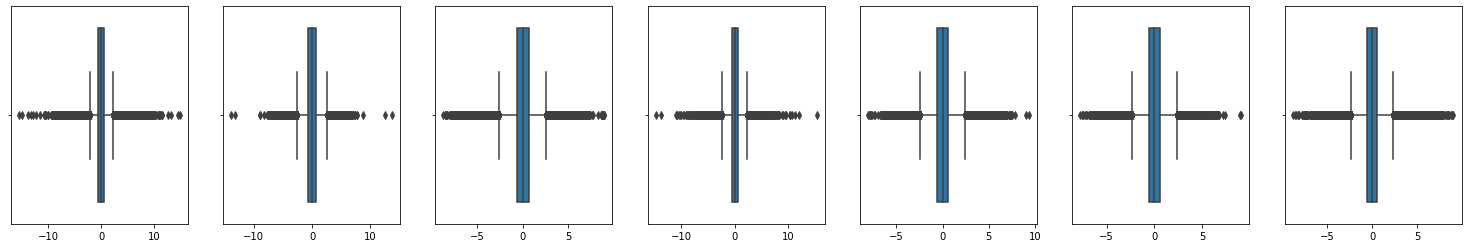

In [ ]:
fig, axes = plt.subplots(1,7, figsize=(26,4))

sns.boxplot(x=np.ravel(X_src1), ax=axes[0])
sns.boxplot(x=np.ravel(X_src2), ax=axes[1])
sns.boxplot(x=np.ravel(X_src3), ax=axes[2])
sns.boxplot(x=np.ravel(X_MIA_LB_target), ax=axes[3])
sns.boxplot(x=np.ravel(X_MIB_LB_target), ax=axes[4])
sns.boxplot(x=np.ravel(X_MIA_FN_target), ax=axes[5])
sns.boxplot(x=np.ravel(X_MIB_FN_target), ax=axes[6])

### relabel data

In [ ]:
y_src1 = np.array([relabel(l) for l in label_src1])
y_src2 = np.array([relabel(l) for l in label_src2])
y_src3 = np.array([relabel(l) for l in label_src3])

y_MIA_LB_target = np.clip(y_MIA_LB_target, a_min = 0, a_max=2)
y_MIB_LB_target = np.clip(y_MIB_LB_target, a_min = 0, a_max=2)
y_MIA_FN_target = np.clip(y_MIA_FN_target, a_min = 0, a_max=2)
y_MIB_FN_target = np.clip(y_MIB_FN_target, a_min = 0, a_max=2)

print("Only right-/left-hand labels are used and first source dataset does not have other labels:")
print(np.unique(y_src1), np.unique(y_src2), np.unique(y_src3))

Only right-/left-hand labels are used and first source dataset does not have other labels:
[0 1] [0 1 2] [0 1 2]


## cut and split

In [ ]:
window_size = min(X_src1.shape[2], X_src2.shape[2], X_src3.shape[2])
#### FOR DEVELOPMENT ####
# tgt_train = m_src3["subject"] <=3
# tgt_val = (m_src3["run"].isin(["run_0", "run_1"])) & (m_src3["subject"] > 3)
# tgt_test = (m_src3["run"].isin(["run_2", "run_3", "run_4", "run_5"])) & (m_src3["subject"] > 3)
# X_train = np.concatenate((X_src1[:, :, :window_size], X_src2[:, :, :window_size], X_src3[tgt_train, :, :window_size]))
# y_train = np.concatenate((y_src1, y_src2, y_src3[tgt_train]))
# X_target = X_src3[tgt_val, :, :window_size]
# y_target = y_src3[tgt_val]
# X_test = X_src3[tgt_test, :, :window_size]
# y_test = y_src3[tgt_test]

# idx_train_target = [0] * (len(y_train) - np.sum(tgt_train)) + [1] * np.sum(tgt_train)


#### FOR LEADERBOARD SUBMISSION #####
# X_train = np.concatenate((X_src1[:, :, :window_size], 
#                           X_src2[:, :, :window_size], 
#                           X_src3[:, :, :window_size]))
# y_train = np.concatenate((y_src1, y_src2, y_src3))
# X_target = np.concatenate((X_MIA_target[:, :, :window_size], X_MIB_target[:, :, :window_size]))
# y_target = np.concatenate((y_MIA_target, y_MIB_target))
# X_test = np.concatenate((X_MIA_test[:, :, :window_size], X_MIB_test[:, :, :window_size]))


#### FOR FINAL SUBMISSION #####
X_train = np.concatenate((X_src1[:, :, :window_size], 
                          X_src2[:, :, :window_size], 
                          X_src3[:, :, :window_size],
                          X_MIA_LB_target[:, :, :window_size],
                          X_MIB_LB_target[:, :, :window_size]))

y_train = np.concatenate((y_src1, y_src2, y_src3, y_MIA_LB_target, y_MIB_LB_target))
X_target = np.concatenate((X_MIA_FN_target[:, :, :window_size], X_MIB_FN_target[:, :, :window_size]))
y_target = np.concatenate((y_MIA_FN_target, y_MIB_FN_target))
X_test = np.concatenate((X_MIA_FN_test[:, :, :window_size], X_MIB_FN_test[:, :, :window_size]))
mixup_data = np.concatenate((X_MIA_LB_test[:, :, :window_size], X_MIB_LB_test[:, :, :window_size], 
                             X_MIA_FN_test[:, :, :window_size], X_MIB_FN_test[:, :, :window_size]))

idx_train_target = [0] * (len(y_src1) + len(y_src2) + len(y_src3)) + [1] * (len(y_MIA_LB_target) + len(y_MIB_LB_target))

#### MIXUP DATA ####
supervised_mixup_data = {}
for c in np.unique(y_target):
    supervised_mixup_data[c] = X_target[y_target == c]
    print(c, np.shape(supervised_mixup_data[c]))


print("Train:  there are {} trials with {} electrodes and {} time samples".format(*X_train.shape))
print("Target: there are {} trials with {} electrodes and {} time samples".format(*X_target.shape))
print("Test: there are {} trials with {} electrodes and {} time samples".format(*X_test.shape))
print("Mixup: there are {} trials with {} electrodes and {} time samples".format(*mixup_data.shape))

print(len(idx_train_target), np.sum(idx_train_target))

0.0 (135, 17, 300)
1.0 (135, 17, 300)
2.0 (270, 17, 300)
Train:  there are 8068 trials with 17 electrodes and 300 time samples
Target: there are 540 trials with 17 electrodes and 300 time samples
Test: there are 1000 trials with 17 electrodes and 300 time samples
Mixup: there are 2000 trials with 17 electrodes and 300 time samples
8068 560


(array([135.,   0.,   0.,   0.,   0., 135.,   0.,   0.,   0., 270.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

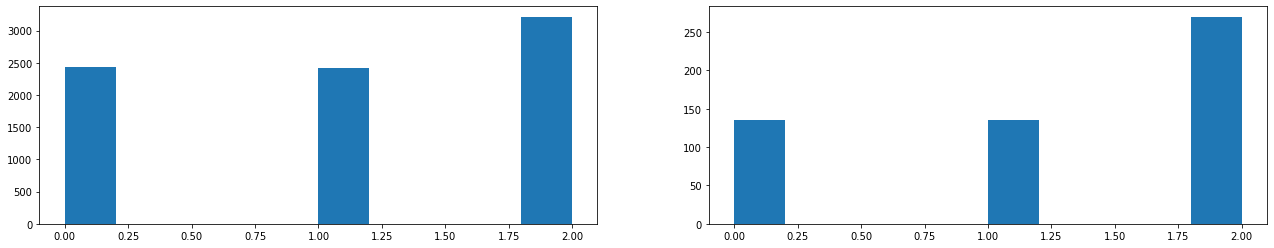

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(22,4))
axes[0].hist(y_train)
axes[1].hist(y_target)

## main

### args

In [ ]:
import json

class base_args(object):
    def __init__(self, model_name, seed=42, n_classes=3):
        self.model_name = model_name
        self.seed = seed
        self.n_classes = n_classes

        self.lr = 1e-3
        self.epochs = 10
        self.batch_size = 60
        self.num_workers = 2
        self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
        self.alpha = 0.01
        self.phase = "base"

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

    def get_model_name(self):
        return f"{self.model_name}_{self.phase}"

in_chans = X_train.shape[1]
labelsize = len(np.unique(y_train))

### training

In [ ]:
def supervised_run(args, model, train_data, train_labels, target_data, target_labels, test_data, mixup_data=None, supervised_mixup_data=None, validate_test=None, idx_train_target=None):
    print(args.toJSON())

    history = {"Train": {"Score": [], "Loss": []}, 
               "Valid": {"Score": [], "Loss": []}}

    ############################
    ### USE ONLY SOURCE DATA ###
    ############################
    args.phase = "base"
    args.epochs = 10

    train_weights = np.array([0.25] * len(idx_train_target))
    train_weights[idx_train_target] = 0.75
    train_sample_rate = 0.5

    train_model(args, model, 
                train_data, train_labels, 
                target_data, target_labels, 
                train_weights = train_weights, sample_rate=train_sample_rate,
                mixup_data=None, supervised_mixup_data=None,
                history=history)
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 1 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    if validate_test is not None:
        validate_model(args, model, validate_test[0], validate_test[1], "Test")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)


    #########################################
    ### SOURCE DATA WITH SUPERVISED MIXUP ###
    #########################################
    args.lr = 1e-3
    args.epochs = 10
    args.phase = "mixup"

    train_model(args, model, 
                train_data, train_labels, 
                target_data, target_labels, 
                supervised_mixup_data=supervised_mixup_data, mixup_rate=0.6,
                history=history,
                validate_test=validate_test)
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 2 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    if validate_test is not None:
        validate_model(args, model, validate_test[0], validate_test[1], "Test")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)

    ###############################
    ### FINETUNE ON TARGET DATA ###
    ###############################
    args.lr = 1e-3
    args.epochs = 20
    args.phase = "mixup_finetuned"
    # prepare extended train data with sampler settings
    extended_train_data = np.concatenate((train_data, target_data))
    extended_train_labels = np.concatenate((train_labels, target_labels))
    train_weights = [0.25] * len(train_labels) + [0.75] * len(target_labels)
    mixup_idx = [True] * len(train_labels) + [False] * len(target_labels)
    train_sample_rate = 0.5

    train_model(args, model, 
                extended_train_data, extended_train_labels,
                target_data, target_labels,
                train_weights = train_weights, sample_rate=train_sample_rate,
                mixup_data=mixup_data, mixup_idx=mixup_idx, mixup_rate=0.4,
                use_scheduler=True, history=history,
                validate_test=validate_test)
    
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 3 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    if validate_test is not None:
        validate_model(args, model, validate_test[0], validate_test[1], "Test")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)
    # plot training history
    plot_history(history)

In [ ]:
args_array = []

In [ ]:
from braindecode.models import EEGResNet, deep4, hybrid

feature shape is:  (1, 64, 14, 1)
feature reduction shape is:  (1, 50, 1, 1)
{
    "alpha": 0.01,
    "batch_size": 60,
    "device": "cuda",
    "epochs": 10,
    "lr": 0.001,
    "model_name": "mi_shallownet-42",
    "n_classes": 3,
    "num_workers": 2,
    "phase": "base",
    "seed": 42
}


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


###### PHASE 1 FINISHED ##########


  0%|          | 0/9 [00:00<?, ?it/s]

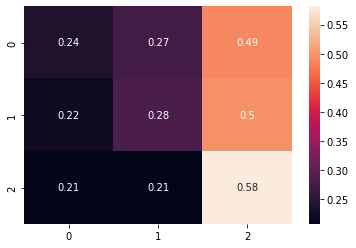

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


###### PHASE 2 FINISHED ##########


  0%|          | 0/9 [00:00<?, ?it/s]

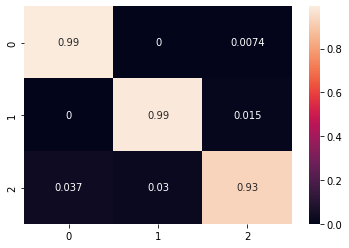

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


###### PHASE 3 FINISHED ##########


  0%|          | 0/9 [00:00<?, ?it/s]

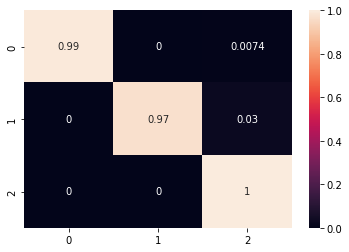

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

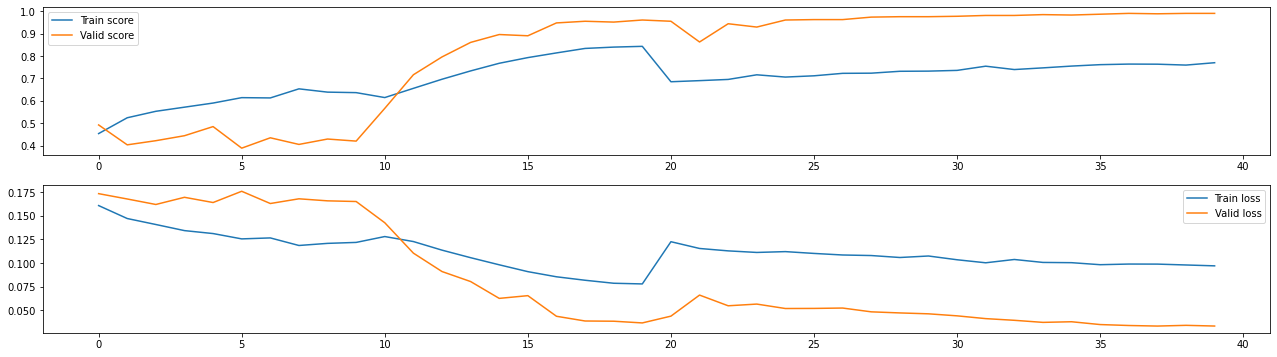

In [ ]:
args = base_args("mi_shallownet-42", n_classes=labelsize)
seed_everything(args.seed)
model = EEGShallowClassifier(in_chans, labelsize, window_size, False)
supervised_run(args, model, X_train, y_train, X_target, y_target, X_test, mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data, idx_train_target=idx_train_target)
args_array.append(args)

In [ ]:
# model

feature shape is:  (1, 64, 14, 1)
feature reduction shape is:  (1, 50, 1, 1)
{
    "alpha": 0.01,
    "batch_size": 60,
    "device": "cuda",
    "epochs": 10,
    "lr": 0.001,
    "model_name": "mi_shallownet-2021",
    "n_classes": 3,
    "num_workers": 2,
    "phase": "base",
    "seed": 2021
}


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


###### PHASE 1 FINISHED ##########


  0%|          | 0/9 [00:00<?, ?it/s]

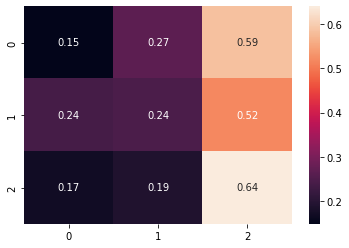

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


###### PHASE 2 FINISHED ##########


  0%|          | 0/9 [00:00<?, ?it/s]

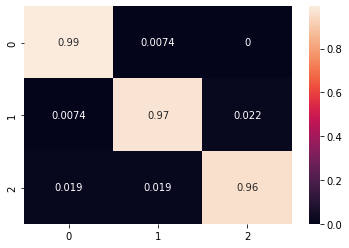

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]


###### PHASE 3 FINISHED ##########


  0%|          | 0/9 [00:00<?, ?it/s]

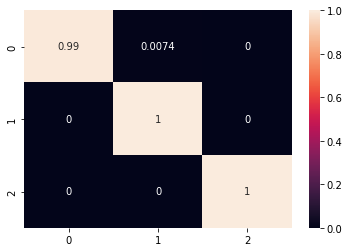

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

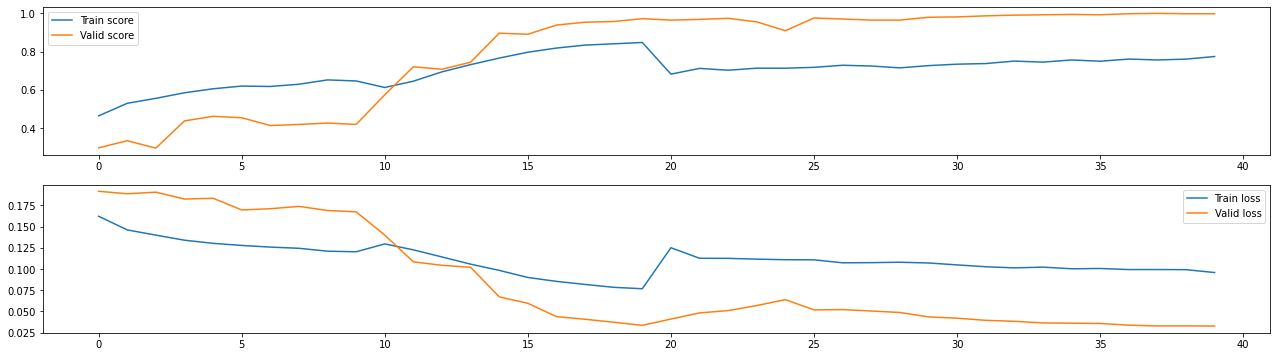

In [ ]:
args = base_args("mi_shallownet-2021", seed=2021, n_classes=labelsize)
seed_everything(args.seed)
model = EEGShallowClassifier(in_chans, labelsize, window_size, False)
supervised_run(args, model, X_train, y_train, X_target, y_target, X_test, mixup_data=mixup_data, supervised_mixup_data=supervised_mixup_data, idx_train_target=idx_train_target)
args_array.append(args)

In [ ]:
target_output = ensemble(args_array, "target", "base")
target_pred = np.argmax(target_output, axis=1)
print("Base model ensemble target accuracy: ", np.mean(target_pred == y_target))

target_output = ensemble(args_array, "target", "mixup")
target_pred = np.argmax(target_output, axis=1)
print("Mixup model ensemble target accuracy: ", np.mean(target_pred == y_target))

# test_output = ensemble(args_array, "test", "base")
# test_pred = np.argmax(test_output, axis=1)
# print("Base model ensemble test accuracy: ", np.mean(test_pred == y_test))

# test_output = ensemble(args_array, "test", "mixup")
# test_pred = np.argmax(test_output, axis=1)
# print("Mixup model ensemble test accuracy: ", np.mean(test_pred == y_test))

test_output = ensemble(args_array, "test")
test_pred = np.argmax(test_output, axis=1)
# print("Mixup finetuned model ensemble test accuracy: ", np.mean(test_pred == y_test))
np.savetxt(f"{OUTPUT_FOLDER}answer.txt", test_pred, delimiter=',',fmt="%d")
# plot_conf_matrix(y_test, test_output)

Base model ensemble target accuracy:  0.42592592592592593
Mixup model ensemble target accuracy:  0.9666666666666667


## save results

In [ ]:
import datetime
from google.colab import files

In [ ]:
archive_folder = f"{datetime.datetime.now():%Y-%m-%d-%H-%M}-mi-mixup_vat"
print(archive_folder)

2021-09-30-15-01-mi-mixup_vat


In [ ]:
files.download(f"{OUTPUT_FOLDER}answer.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%notebook -e {OUTPUT_FOLDER}notebook_run.ipynb

In [ ]:
!cp -R {OUTPUT_FOLDER} GDRIVE_OUTPUT_FOLDER{archive_folder}

(1000,)
[2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 1 1 0 1 1 2 2 0 0 2 2 2 2 2 2 1 2 2 2 1
 0 2 2 2 0 2 2 1 2 2 1 2 2 2 0 2 0 2 0 1 2 2 2 2 2 1 2 1 2 2 1 0 2 2 2 0 2
 2 0 2 1 2 2 2 1 2 2 0 2 2 1 2 2 2 0 0 2 2 2 0 1 2 2 0 1 2 0 2 2 1 2 1 2 1
 0 2 2 2 2 2 2 2 2 1 2 0 2 2 2 0 2 1 2 0 0 2 2 2 1 1 1 0 0 2 0 0 2 2 2 1 1
 2 2 1 0 1 1 1 2 2 2 1 2 2 2 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 1 1 2
 2 1 1 1 2 0 2 2 2 2 2 0 2 2 2]


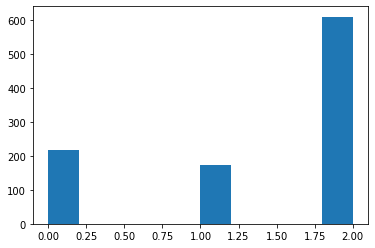

In [ ]:
plt.hist(test_pred)
print(np.shape(test_pred))
print(test_pred[:200])